In [78]:
from music21 import converter, instrument, note, chord, stream
import numpy
from matplotlib import pyplot as plt
import keras
from sklearn.preprocessing import OneHotEncoder
from keras import Sequential, Model
from keras.layers import LSTM, Dropout, Dense, Activation, Input, concatenate
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Embedding


In [51]:
midi = converter.parse("pathetique_3.mid")
midi

<music21.stream.Score 0x790359b979a0>

In [53]:
print(len(midi.flatten().notes))

2117


In [ ]:
for element in midi.flatten().notes:
  if isinstance(element , note.Note):
    print(element , element.offset, element.pitch)
  if isinstance(element, chord.Chord):
     print(element, element.offset, '+'.join(str(n) for n in element.normalOrder))


In [55]:
notes = []

for element in midi.flatten().notesAndRests:
  if isinstance(element , note.Note):
    notes.append((float(element.offset), float(element.volume.velocity),float(element.seconds), str(element.pitch)))
  elif isinstance(element, chord.Chord):
     notes.append((float(element.offset), float(element.volume.velocity), float(element.seconds), '+'.join(str(n) for n in element.normalOrder)))
  elif isinstance(element, note.Rest):
      # Bizarre car main gauche et droite flatten (réunie)
      # Voir autre implémentation
      notes.append((float(element.offset), 0,float(element.seconds), "REST"))

In [56]:
notes

[(0.0, 0, 0.7246726895019083, 'REST'),
 (0.0, 0, 0.7246726895019083, 'REST'),
 (2.5, 48.0, 0.07415097137772506, 'G4'),
 (2.5, 0, 0.2966038855109002, 'REST'),
 (2.75, 0, 0.07415097137772506, 'REST'),
 (3.0, 49.0, 0.07415097137772506, 'C5'),
 (3.25, 0, 0.07415097137772506, 'REST'),
 (3.5, 51.0, 0.07890583903208838, 'D5'),
 (3.5, 0, 0.15781167806417676, 'REST'),
 (3.75, 0, 0.07890583903208838, 'REST'),
 (4.0, 52.0, 0.43480361370114495, 'E-5'),
 (4.0, 40.0, 0.14493453790038166, 'C3'),
 (4.5, 36.0, 0.14645577035735208, 'E-3'),
 (5.0, 36.0, 0.14645577035735208, 'G3'),
 (5.5, 50.0, 0.15491066818134877, 'F5'),
 (5.5, 36.0, 0.15491066818134877, 'C4'),
 (6.0, 53.0, 0.43398591956794297, 'D5'),
 (6.0, 40.0, 0.1446619731893143, 'C3'),
 (6.5, 40.0, 0.14645577035735208, 'F3'),
 (7.0, 36.0, 0.14645577035735208, 'G3'),
 (7.5, 50.0, 0.1541148669474982, 'E-5'),
 (7.5, 36.0, 0.1541148669474982, 'B3'),
 (8.0, 52.0, 0.5072708826513358, 'C5'),
 (8.0, 0, 1.0870090342528624, 'REST'),
 (8.0, 40.0, 0.14493453790

In [57]:
def check_pitch(x):
  if ('+' in x) or x.isdigit():
        notes_in_chord = x.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord =chord.Chord(notes).pitches[0].midi
        return new_chord
    # pattern is a note
  elif ("REST" in x):
    return 0
  else:
        new_note = note.Note(x).pitch.midi
        return new_note

In [58]:
df = pd.DataFrame(notes, columns=['debut_note','volume','durée(s)', 'pitch/chord'])
df



,debut_note,volume,durée(s),pitch/chord
0,0.00,0.0,0.724673,REST
1,0.00,0.0,0.724673,REST
2,2.50,48.0,0.074151,G4
3,2.50,0.0,0.296604,REST
4,2.75,0.0,0.074151,REST
...,...,...,...,...
2819,839.75,0.0,0.073529,REST
2820,840.00,101.0,0.294118,C5
2821,840.00,72.0,0.294118,0+3+7
2822,841.00,0.0,0.900000,REST


In [59]:
df['MIDI Pitch'] = df['pitch/chord'].apply(lambda x: check_pitch(x))


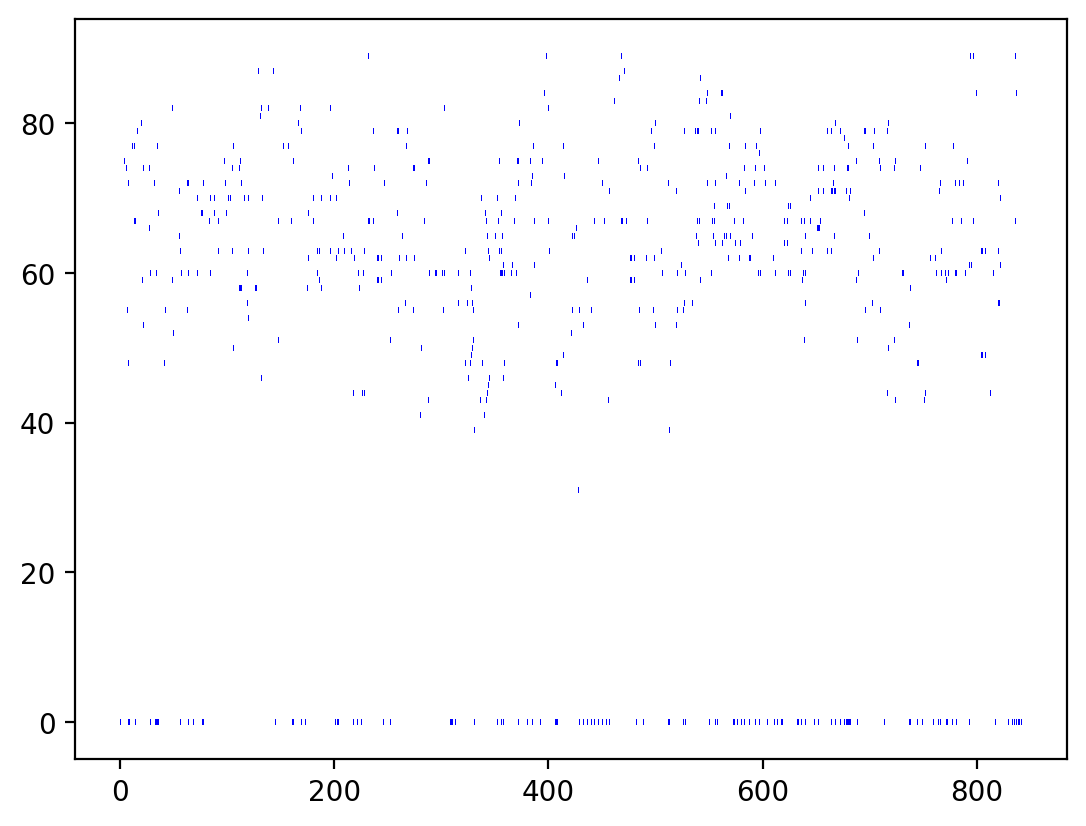

In [11]:
fig, ax = plt.subplots()

for index, row in df.iterrows():
    start = row['debut_note']
    duration = row['durée(s)']
    pitch = row['MIDI Pitch']

    ax.broken_barh([(float(start), float(duration))], (float(pitch) - 0.4, 0.8), facecolors='blue')


In [60]:
df

,debut_note,volume,durée(s),pitch/chord,MIDI Pitch
0,0.00,0.0,0.724673,REST,0
1,0.00,0.0,0.724673,REST,0
2,2.50,48.0,0.074151,G4,67
3,2.50,0.0,0.296604,REST,0
4,2.75,0.0,0.074151,REST,0
...,...,...,...,...,...
2819,839.75,0.0,0.073529,REST,0
2820,840.00,101.0,0.294118,C5,72
2821,840.00,72.0,0.294118,0+3+7,60
2822,841.00,0.0,0.900000,REST,0


<Axes: ylabel='Frequency'>

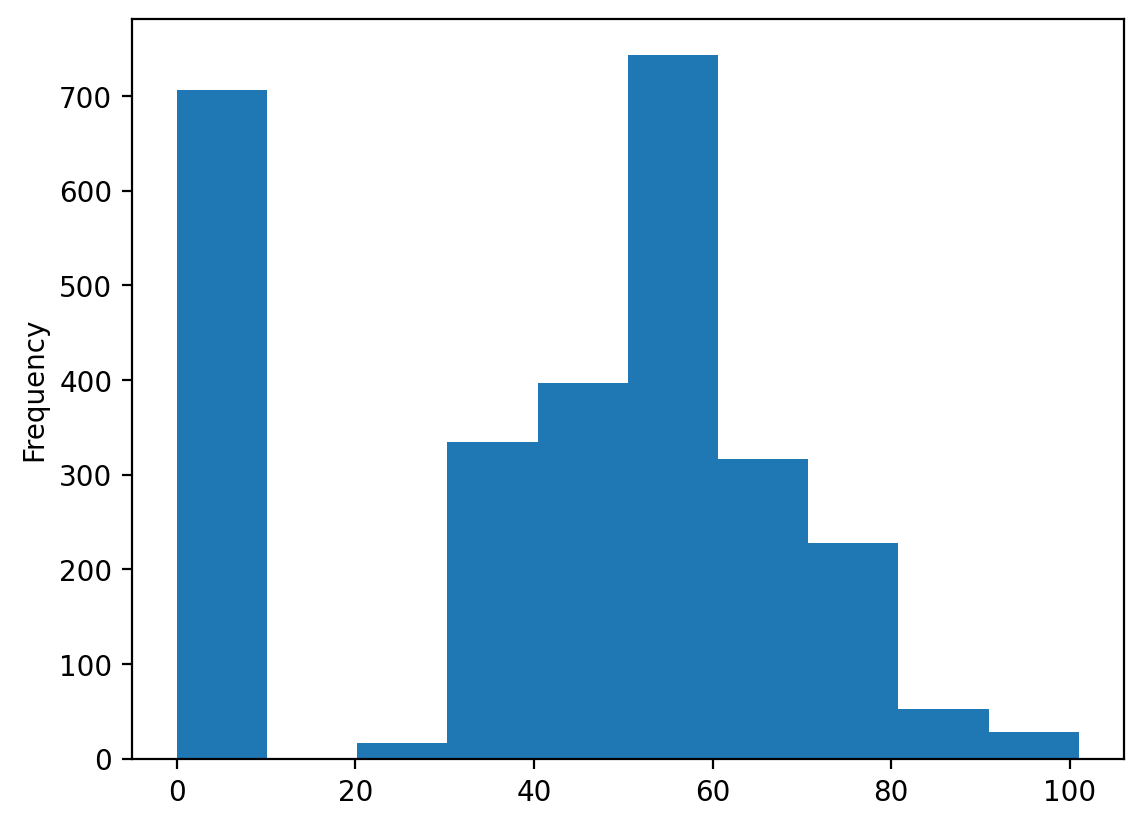

In [61]:
df.volume.plot(kind='hist')

<Axes: ylabel='Frequency'>

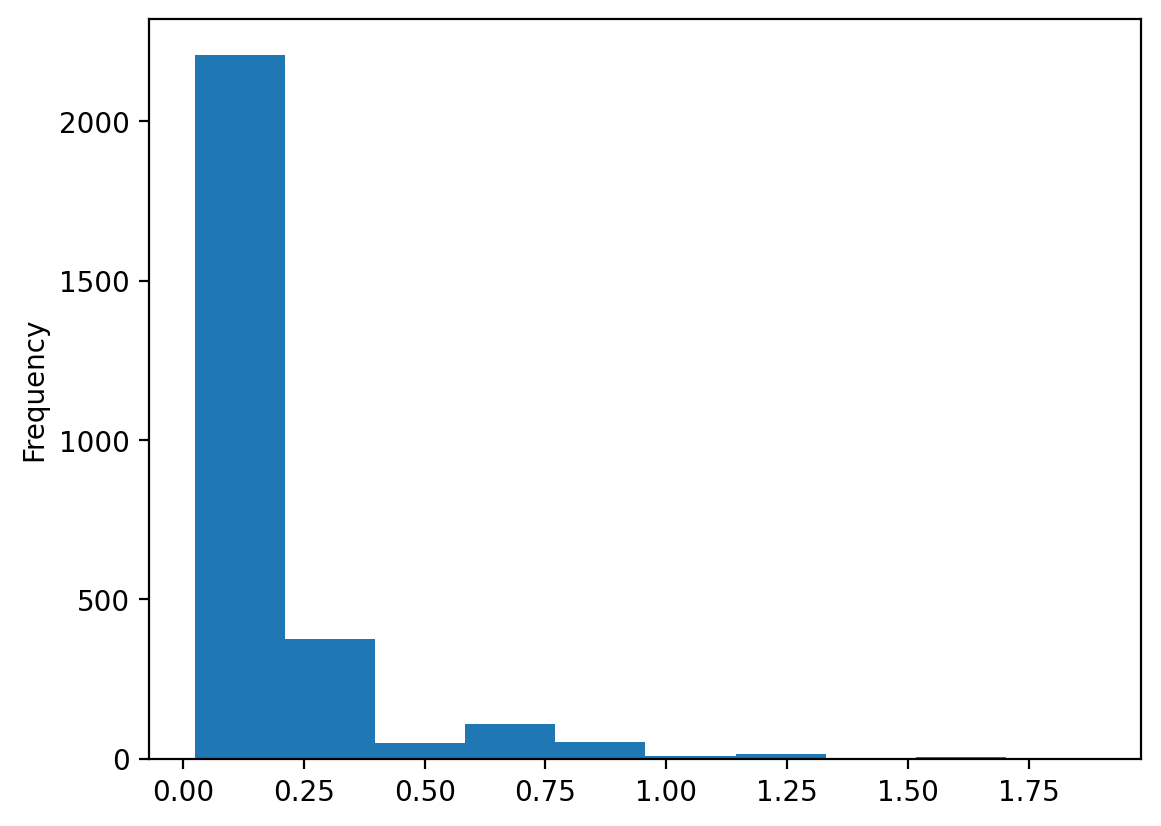

In [62]:
df["durée(s)"].plot(kind="hist")

In [63]:
df

,debut_note,volume,durée(s),pitch/chord,MIDI Pitch
0,0.00,0.0,0.724673,REST,0
1,0.00,0.0,0.724673,REST,0
2,2.50,48.0,0.074151,G4,67
3,2.50,0.0,0.296604,REST,0
4,2.75,0.0,0.074151,REST,0
...,...,...,...,...,...
2819,839.75,0.0,0.073529,REST,0
2820,840.00,101.0,0.294118,C5,72
2821,840.00,72.0,0.294118,0+3+7,60
2822,841.00,0.0,0.900000,REST,0


In [64]:
oh_notes =  OneHotEncoder().fit(df[['pitch/chord']])
notes_encoded = oh_notes.transform(df[['pitch/chord']]).toarray()

In [66]:
note_data = notes_encoded
offset_data = df["debut_note"]
volume_data = df["volume"]
duration_data = df["durée(s)"]

In [67]:
sequence_length = 100


def prepare_sequence(data):
  network_input = []
  network_output = []
  # create input sequences and the corresponding outputs
  for i in range(0, len(notes) - sequence_length, 1):
      sequence_in = data[i:i + sequence_length]
      sequence_out = data[i + sequence_length]
      network_input.append(sequence_in)
      network_output.append(sequence_out)

  n_patterns = len(network_input)
  network_input = numpy.reshape(network_input, (n_patterns, sequence_length, -1))
  network_output = numpy.reshape(network_output, (len(network_output), -1))

  return (network_input, network_output)


In [68]:
input_note, output_note = prepare_sequence(note_data)
input_offset, output_offset = prepare_sequence(offset_data)
input_volume, output_volume = prepare_sequence(volume_data)
input_duration, output_duration = prepare_sequence(duration_data)

In [71]:
print(input_note.shape)
print(output_volume.shape)


(2724, 100, 111)
(2724, 1)


In [84]:
inputNotes_layer = Input(shape=(input_note.shape[1], input_note.shape[2]))
inputNotes = LSTM(
        64,
        input_shape=(input_note.shape[1], input_note.shape[2]),
        return_sequences=True
    )(inputNotes_layer)
inputOffset_layer = Input(shape=(input_offset.shape[1], input_offset.shape[2]))
inputOffset = LSTM(
        64,
        input_shape=(input_offset.shape[1], input_offset.shape[2]),
        return_sequences=True
    )(inputOffset_layer)
inputVolume_layer = Input(shape=(input_volume.shape[1], input_volume.shape[2]))
inputVolume = LSTM(
        64,
        input_shape=(input_volume.shape[1], input_volume.shape[2]),
        return_sequences=True
    )(inputVolume_layer)
inputDuration_layer = Input(shape=(input_duration.shape[1], input_duration.shape[2]))
inputDuration = LSTM(
        64,
        input_shape=(input_duration.shape[1], input_duration.shape[2]),
        return_sequences=True
    )(inputDuration_layer)

inputs = concatenate([inputNotes])
x = LSTM(128, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = LSTM(128)(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)

outputNotes = Dense(64, activation='relu')(x)
outputNotes = Dense(output_note.shape[1], activation='softmax', name="Note")(outputNotes)

outputOffset = Dense(64, activation='relu')(x)
outputOffset = Dense(output_offset.shape[1], activation='softmax', name="Offset")(outputOffset)

outputVolume = Dense(64, activation='relu')(x)
outputVolume = Dense(1, activation='softmax', name="Volume")(outputVolume)

outputDuration = Dense(12, activation='relu')(x)
outputDuration = Dense(1, activation='softmax', name="Duration")(outputDuration)


model = Model(inputs=[inputNotes_layer, inputOffset_layer, inputVolume_layer, inputDuration_layer], outputs=[outputNotes, outputOffset, outputVolume, outputDuration])

#Adam seems to be faster than RMSProp and learns better too
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.summary()

In [74]:
import os

cp_callback = keras.callbacks.ModelCheckpoint(
    'model_weights_epoch_{epoch:02d}.h5',  # Nom du fichier de sauvegarde avec un espace réservé pour le numéro de l'époque
    save_best_only=False,  # Sauvegarder à chaque époque, pas seulement les meilleurs modèles
    save_weights_only=True,  # Sauvegarder uniquement les poids, pas l'ensemble du modèle
    verbose=1  # Afficher un message lors de la sauvegarde
    )

In [85]:
model.fit([input_note, input_offset, input_volume, input_duration], [output_note, output_offset, output_volume, output_duration], epochs=400, callbacks=[cp_callback])

Epoch 1/400
86/86 [==============================] - ETA: 0s - loss: 4.0182 - Note_loss: 4.0182 - Offset_loss: 0.0000e+00 - Volume_loss: 0.0000e+00 - Duration_loss: 0.0000e+00
Epoch 1: saving model to model_weights_epoch_01.h5
86/86 [==============================] - 50s 477ms/step - loss: 4.0182 - Note_loss: 4.0182 - Offset_loss: 0.0000e+00 - Volume_loss: 0.0000e+00 - Duration_loss: 0.0000e+00
Epoch 2/400
86/86 [==============================] - ETA: 0s - loss: 3.7596 - Note_loss: 3.7596 - Offset_loss: 0.0000e+00 - Volume_loss: 0.0000e+00 - Duration_loss: 0.0000e+00
Epoch 2: saving model to model_weights_epoch_02.h5
86/86 [==============================] - 53s 615ms/step - loss: 3.7596 - Note_loss: 3.7596 - Offset_loss: 0.0000e+00 - Volume_loss: 0.0000e+00 - Duration_loss: 0.0000e+00
Epoch 3/400
25/86 [=======>......................] - ETA: 37s - loss: 3.8615 - Note_loss: 3.8615 - Offset_loss: 0.0000e+00 - Volume_loss: 0.0000e+00 - Duration_loss: 0.0000e+00

KeyboardInterrupt: ignored

In [30]:
import random

In [112]:
start = numpy.random.randint(0, len(input_note)-1)
start2 = numpy.random.randint(0, len(input_offset)-1)
start3 = numpy.random.randint(0, len(input_volume)-1)
start4 = numpy.random.randint(0, len(input_duration)-1)


pattern_note = input_note[start]
pattern_offset = input_offset[start2]
pattern_volume = input_volume[start3]
pattern_duration = input_duration[start4]

In [113]:
input_note[start]

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [114]:
prediction_output = []
for note_index in range(500):
    note_prediction_input = numpy.reshape(pattern_note, (1, len(pattern_note), -1))
    print(note_prediction_input.shape)

		#print(note_prediction_input.shape)

		#print(n_vocab_notes)
		#print(n_vocab_offsets)
		#print(n_vocab_durations)


    offset_prediction_input = numpy.reshape(pattern_offset, (1, len(pattern_offset), -1))

    duration_prediction_input = numpy.reshape(pattern_duration, (1, len(pattern_duration), -1))
    volume_prediction_input = numpy.reshape(pattern_volume, (1, len(pattern_volume), -1))

    prediction = model.predict([note_prediction_input, offset_prediction_input, volume_prediction_input, duration_prediction_input], verbose=0)
    print(prediction)
    index = prediction[0]
		#print(index)
    result = oh.inverse_transform(index)
		#print(result)

    offset = prediction[1]

    volume = (prediction[2])

    duration = (prediction[3])



    prediction_output.append([result, offset, volume, duration])

    pattern_note = numpy.append(pattern_note, index)
    pattern_offset = numpy.append(pattern_offset, offset)
    pattern_duration = numpy.append(pattern_duration, duration)
    pattern_volume = numpy.append(pattern_volume, volume)

    pattern_note = pattern_note[1:len(pattern_note)]
    pattern_volume = pattern_volume[1:len(pattern_volume)]

    pattern_offset = pattern_offset[1:len(pattern_offset)]
    pattern_duration = pattern_duration[1:len(pattern_duration)]

(1, 100, 111)
[array([[0.00790701, 0.002926  , 0.00345966, 0.00167521, 0.0009493 ,
        0.0053427 , 0.00068251, 0.00585018, 0.0022008 , 0.00613421,
        0.00089662, 0.00083904, 0.00100499, 0.00307995, 0.00241131,
        0.00543795, 0.00015194, 0.00075514, 0.00056919, 0.00164649,
        0.00083885, 0.00731064, 0.00080836, 0.00229589, 0.00219714,
        0.00339223, 0.00067137, 0.00075358, 0.00020184, 0.00095634,
        0.00446367, 0.00108163, 0.00046562, 0.00791125, 0.00625286,
        0.00248913, 0.00148935, 0.00215286, 0.00021325, 0.00222856,
        0.00227581, 0.00703216, 0.00288975, 0.00025727, 0.00191242,
        0.0014664 , 0.01052982, 0.00180089, 0.00506429, 0.00451388,
        0.00330586, 0.00856157, 0.00255346, 0.00180304, 0.00140253,
        0.00266909, 0.00403007, 0.00264085, 0.01440606, 0.00232681,
        0.0086962 , 0.00501836, 0.00731945, 0.00457549, 0.01013919,
        0.00237552, 0.00666782, 0.0159461 , 0.01495564, 0.00263999,
        0.00664174, 0.00492957, 0

InvalidArgumentError: ignored

In [ ]:
prediction_output

In [ ]:
midi_stream = stream.Stream(prediction_output)
midi_stream.write('midi', fp='test_output.mid')

NameError: ignored